youtube https://www.youtube.com/watch?v=VMj-3S1tku0&t=6588s

In [2]:
import random
import numpy as np

In [3]:
# Define a class Value
class Value:

    # Initialize the class
    def __init__(self, data, _children = (), _op = '',label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # Define the __repr__ method
    def __repr__(self):
        return f'Value({self.data})'
    
    # Define the __add__ method
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+' )

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # for commutative property, which is called in the case : 2 + a
        return self.__add__(other)
    
    # Define the __mul__ method
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # for commutative property, which is called in the case : 2 * a
        return self.__mul__(other)

    def __pow__(self,other):
        assert isinstance(other, (int, float)), 'The power must be a int ot a float'
        out = Value(self.data ** other, (self,), '**')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    # division
    def __truediv__(self, other):
        return self * (other ** -1)
    
    #negation
    def __neg__(self):
        return self * -1
    
    #subtraction
    def __sub__(self,other):
        return self + (-other)
    
    # Define the activation function
    def tanh(self):
        out =  Value(np.tanh(self.data), (self,), 'tanh')

        def _backward():
            self.grad = (1 - np.tanh(self.data)**2) * out.grad
        out._backward = _backward
        return out

    # define the exp function
    def exp(self):
        out = Value(np.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += np.exp(self.data) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        #build the topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for prev in v._prev:
                    build_topo(prev)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
from graphviz import Digraph

def trace(root):
    #builds a graph of the computation
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for prev in v._prev:
                edges.add((prev, v))
                build(prev)
    build(root)
    return nodes, edges

# Define a function to build a graph using graphviz
def make_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        #for each node, we add a rectangular node to the graph
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad ), shape = 'record' )

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        #for each edge, we add an edge to the graph
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [1]:
class Neuron:
    def __init__(self,nin):
        # self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # self.b = Value(random.uniform(-1,1))
        self.w = [Value(0.5) for _ in range(nin)]
        self.b = Value(0.5)
    
    def __call__(self,x):
        # w * x + b
        act = sum((wi * xi for wi,xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self,nin,nout):
        self.neurons= [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x 
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [9]:
xs = [
    [1.0,3.0,2.0],
    [-3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [-1.0,1.0,-1.0],  
]
ys = [1.0,-1.0,1.0,-1.0] #labels

n = MLP(3,[4,4,1])

In [6]:
cycles = 10
for k in range(cycles):
   #forward pass
    ypreds = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout,ygt in zip(ypreds,ys))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update weights
    for p in n.parameters():
        p.data += - 0.01 * p.grad
        
        

    print(k,loss.data)

Value(3.5)
Value(3.5)
Value(3.5)
Value(3.5)
Value(2.4963557952223976)
Value(2.4963557952223976)
Value(2.4963557952223976)
Value(2.4963557952223976)
Value(2.4730340827661266)
Value(-1.25)
Value(-1.25)
Value(-1.25)
Value(-1.25)
Value(-1.1965672799150258)
Value(-1.1965672799150258)
Value(-1.1965672799150258)
Value(-1.1965672799150258)
Value(-1.1652091158816131)
Value(1.75)
Value(1.75)
Value(1.75)
Value(1.75)
Value(2.382751076994575)
Value(2.382751076994575)
Value(2.382751076994575)
Value(2.382751076994575)
Value(2.4662133769904275)
Value(0.0)
Value(0.0)
Value(0.0)
Value(0.0)
Value(0.5)
Value(0.5)
Value(0.5)
Value(0.5)
Value(1.4242343145200194)
0 3.605739537129479
Value(3.494237790209353)
Value(3.494237790209353)
Value(3.494237790209353)
Value(3.494237790209353)
Value(2.493655875679724)
Value(2.493655875679724)
Value(2.493655875679724)
Value(2.493655875679724)
Value(2.4534827565244024)
Value(-1.2665001753168503)
Value(-1.2665001753168503)
Value(-1.2665001753168503)
Value(-1.266500175316850

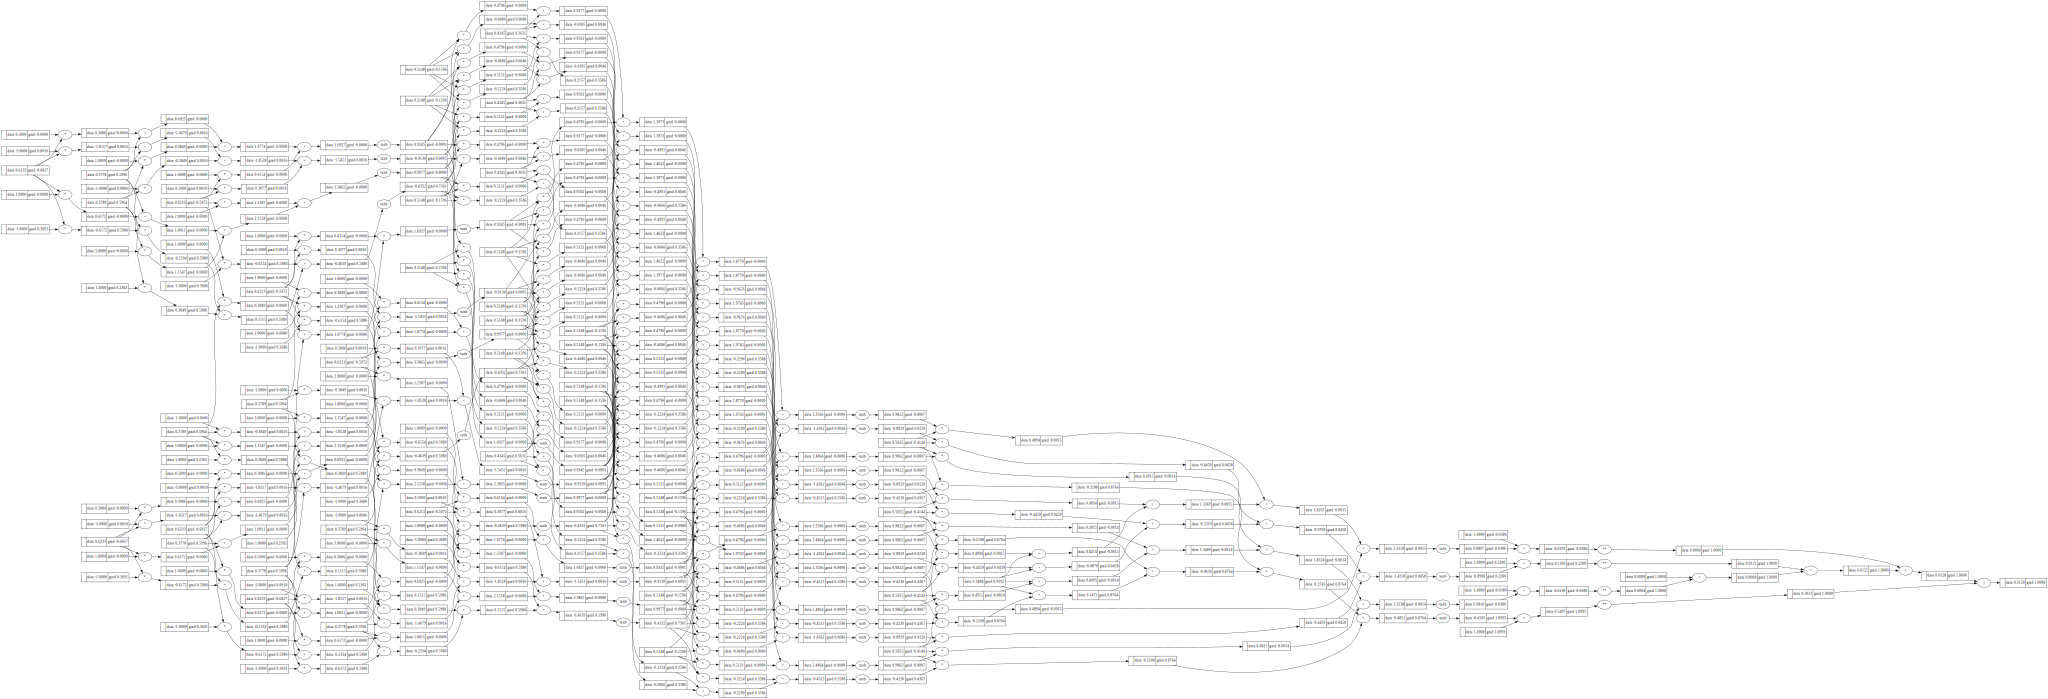

In [7]:
make_dot(loss)

In [8]:
x_test = [-3.0,-1.0,7.0]
y_predicted = n(x_test)
y_predicted

Value(2.4784617496270567)
Value(2.4784617496270567)
Value(2.4784617496270567)
Value(2.4784617496270567)
Value(2.4650626123605646)
Value(2.4650626123605646)
Value(2.4650626123605646)
Value(2.4650626123605646)
Value(2.329781897712266)


Value(0.9812365160789511)